# Homework: Introduction to Time Series

##### Summary
- Measuring error with MAPE
- Selecting parameters in exponential smoothing
- Comparing ARIMA and SARIMA
- Holiday effects with Facebook's Prophet library

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1. Measuring Error with MAPE

The Mean Absolute Percentage Error (MAPE) is a common metric for measuring error in forecasts. The MAPE represents error as a percentage of the actual observed values. A high MAPE value means the error is large relative to the quantity being measuring and so the forecast is poor. A small MAPE means the error is relatively small so the forecast is good.

The MAPE is given by:

$$ MAPE = \frac{1}{n} \sum_{i=1}^{n} \frac{|F_t - A_t|}{A_t} $$

where $A_t$ is the actual observed value, $F_t$ is the forecast, and $n$ is the number of data points the MAPE is being calculated over. Read about MAPE at https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

**A. Write a function `get_mape` that calculates the MAPE for a set of forecasts and actuals. The inputs to the function are two <i> pd.series called </i> `actuals` and `forecasts`. The function returns the MAPE as decimal rounded to 4 decimal places (i.e. MAPE = 0.1032)**

In [69]:
def get_mape(actuals, forecasts):
    
    ### YOUR CODE HERE
    mape = np.mean(abs(actuals-forecasts)/actuals)

    return round(mape,4) 

## 2. Selecting Parameters in Exponential Smoothing

**A. Plot the avocado weekly sales dataset to understand the trend and seasonality. Does the trend appear to be multiplicative or additive? Does the seasonality appear to be multiplicative or additive?**

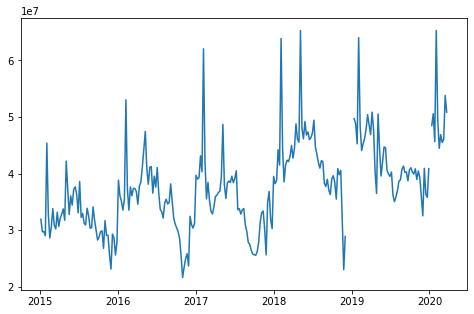

In [51]:
# Read in and process the weekly avocado sales dataset
avocado = pd.read_csv('avocado_sales.csv')

def convert_to_datetime(df, freq):
    df["Date"]= pd.to_datetime(df["Date"])
    df.sort_values(by ='Date', ascending = True, inplace = True)
    df.set_index("Date", inplace = True)
    output_df = df.asfreq(freq)
    return output_df

avocado = convert_to_datetime(avocado, 'W-Sun')

### YOUR CODE ###

plt.rcParams['figure.figsize'] = (8,5)
plt.plot(avocado);

<i>Sometimes if we create a scatter plot it's easier to visualize the time series if there are many outliers/holidays. </i>

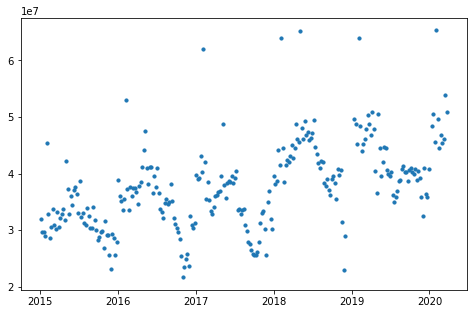

In [340]:
plt.scatter(x = avocado.index, y = avocado['Units Sold'], s = 10 );

<i>The trend and seasonality appear to be **additive**. (In practice, this may be hard to tell and using mutliplicative or additive trends/seasonality may not make a large difference)</i>

**B. Use Triple Exponential Smoothing to create weekly avocado sales forecasts for June 2018 and onward (95 weeks into the future). Fit a model with parameter values recommended by the model and train on data collected from May 2018 and prior.**

- `trend` = [FROM PART A]
- `seasonal` = [FROM PART A]
- `seasonal_periods` = ?
- `smoothing_level` = Recommended by model
- `smoothing_slope` = Recommended by model
- `smoothing_seasonal` = Recommended by model

Hint: Remember we can let the model recommend parameters by passing no inputs into the `fit` method:  `ExponentialSmoothing(...).fit()`

C:\Users\Chad\.conda\envs\data-x\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning:

invalid value encountered in less_equal

C:\Users\Chad\.conda\envs\data-x\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal



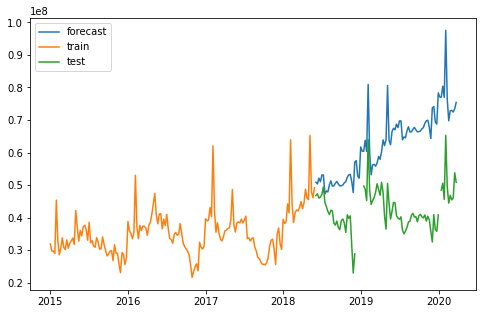

In [332]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### YOUR CODE HERE

train = avocado[avocado.index <= '2018-05-31']
test = avocado[avocado.index >= '2018-06-01']

model = ExponentialSmoothing(train['Units Sold'], 
                             trend = 'additive',
                             seasonal = 'additive',
                             seasonal_periods = 52)

# Fit models
fit = model.fit()

# Forecast 95 months out
pred = fit.forecast(95)

# Plot the training set, forecast, and test set
plt.plot(pred, label = 'forecast')
plt.plot(train['Units Sold'], label = 'train')
plt.plot(test['Units Sold'], label = 'test')
plt.legend();

**C. Now use Triple Exponential Smoothing to create weekly avocado sales forecasts for June 2018 and onward (95 weeks into the future) but use the following model parameters. Again fit a model on the training data collected from May 2018 and prior. Is the forecast better when the model recommends parameters or with these values?** 
- `trend` = [FROM PART A]
- `seasonal` = [FROM PART A]
- `seasonal_periods` = ?
- `smoothing_level` = 0.2
- `smoothing_slope` = 0.2 
- `smoothing_seasonal` = 0.2

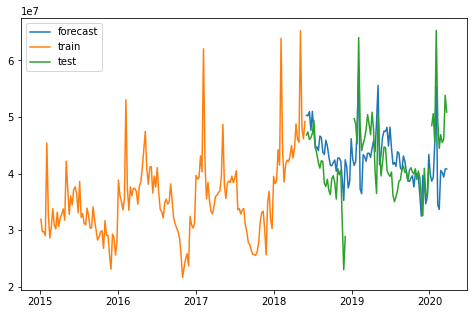

In [333]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### YOUR CODE HERE

train = avocado[avocado.index <= '2018-05-31']
test = avocado[avocado.index >= '2018-06-01']

model = ExponentialSmoothing(train['Units Sold'], 
                             trend = 'additive',
                             seasonal = 'additive',
                             seasonal_periods = 52)

# Fit models
fit = model.fit(smoothing_level = 0.8, smoothing_slope = 0.2, smoothing_seasonal = 0.2)

# Forecast 95 months out
pred = fit.forecast(95)

plt.plot(pred, label = 'forecast')
plt.plot(train['Units Sold'], label = 'train')
plt.plot(test['Units Sold'], label = 'test')
plt.legend();

<i> The forecast with these parameters is better! This is important point: Be careful and visually inspect a forecast when letting the model select parameters.

**D. Calculate the MAPE as the `smoothing_slope` parameter changes from 0.01 to 1 in intervals of 0.01. Train your model on all data from May 2018 and prior. Calculate the MAPE by comparing the 95 weeks of forecasts to the test set (June 2018 and onward). Record the MAPE values in a list called `mapes` where the first element is calculated with beta = 0.01 and the last value is calculated with beta = 1.**

In [334]:
train = avocado[avocado.index <= '2018-05-31']
test = avocado[avocado.index >= '2018-06-01']


### YOUR CODE HERE

def score_train_model(model, beta):
    # Fit models
    fit = model.fit(smoothing_level = 0.2, smoothing_slope = beta, smoothing_seasonal = 0.2)

    # Forecast 95 months out
    pred = fit.forecast(95)
    return get_mape(test['Units Sold'], pred)


model = ExponentialSmoothing(train['Units Sold'], 
                             trend = 'additive',
                             seasonal = 'additive',
                             seasonal_periods = 52)

mapes = []
betas = np.arange(0.1, 1.0, 0.01)

for b in betas:
    score = score_train_model(model, b)
    mapes.append(score)

C:\Users\Chad\.conda\envs\data-x\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Chad\.conda\envs\data-x\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Chad\.conda\envs\data-x\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



We'll plot the error below. We should see that the error is minimized when beta is between about 0.2 and 0.4. A similar searching method can be used to select the other parameter values.

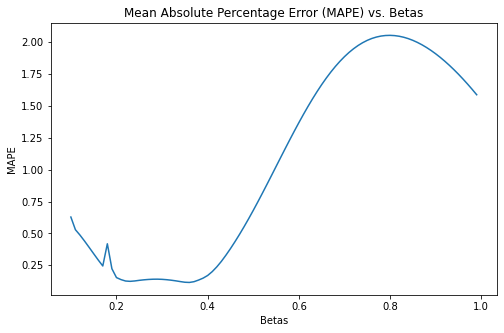

In [335]:
# Plot MAPE against Betas
plt.plot(betas, mapes)
plt.xlabel('Betas')
plt.ylabel('MAPE')
plt.title('Mean Absolute Percentage Error (MAPE) vs. Betas');

## 3. Comparing ARIMA and SARIMA Models

**A. Use an ARIMA model to forecast weekly avocado sales for June 2018 and onward (95 weeks into the future). Train the model on the data from May 2018 and prior. Use the following  parameters. Then plot the ARIMA forecast, test set, and training set.**
- Differencing order = 1
- Autoregressive order = 1
- Moving average order = 1

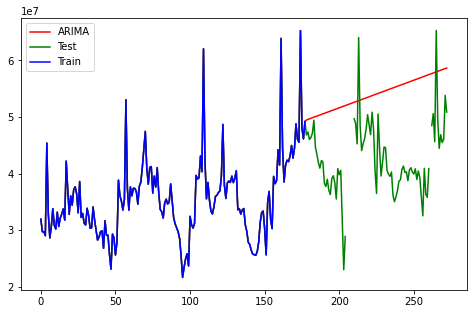

In [284]:
from statsmodels.tsa.arima_model import ARIMA

### YOUR CODE HERE
model = ARIMA(train['Units Sold'], order=(1,1,1))
model_fit = model.fit()
output = model_fit.forecast(95)
arima_pred = output[0]

plt.plot(np.concatenate([np.asarray(train['Units Sold']), arima_pred]), c = 'r', label = 'ARIMA')
plt.plot(np.concatenate([np.asarray(train['Units Sold']), test['Units Sold']]), c = 'g', label = 'Test')
plt.plot(np.asarray(train['Units Sold']), c = 'b', label = 'Train')
plt.legend();

**B. Use a SARIMA model to forecast weekly avocado sales for June 2018 and onward (95 weeks into the future). Train the model on the data from May 2018 and before. Use the following  parameters. Then plot the SARIMA forecast, test set, and training set.**
- Differencing order = 1
- Autoregressive order = 1
- Moving average order = 1
- Seasonal differencing order = 1
- Seasonal autoregressive order = 1
- Seasonal moving average order = 1

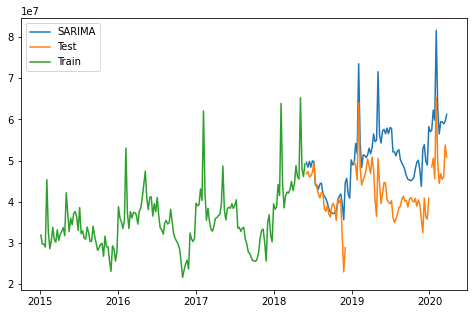

In [287]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### YOUR CODE HERE
# define model
model = SARIMAX(train['Units Sold'], order=(1,1,1), seasonal_order=(1,1,1,52))

# fit model
model_fit = model.fit()

sarima_pred = model_fit.forecast(95)
plt.plot(sarima_pred, label = 'SARIMA')
plt.plot(test['Units Sold'], label = 'Test')
plt.plot(train['Units Sold'], label = 'Train')
plt.legend();

**C. Calculate the MAPE of the ARIMA and SARIMA forecasts by comparing the 95 weeks of forecasts to the test set. How much did the MAPE improve when seasonality was accounted for?**

In [341]:
### YOUR CODE HERE

arima_mape = get_mape(arima_pred, test['Units Sold'])
sarima_mape = get_mape(sarima_pred, test['Units Sold'])

print('ARIMA MAPE: ', arima_mape)
print('SARIMA MAPE: ', sarima_mape)
print('Improvement: ', arima_mape - sarima_mape)

ARIMA MAPE:  0.2202
SARIMA MAPE:  0.1553
Improvement:  0.06490000000000001


## 4. Holiday Effects with Facebook's Prophet library

**A. Use Prophet to forecast weekly avocado sales for June 2018 and onward (95 weeks into the future). Train the model on the data from May 2018 and before. Use Prophet's default parameters.**

In [342]:
from fbprophet import Prophet

# Prophet requires the time series to be a 2 column data series with the Date as 'ds' and the values as 'y'.
avocado_prophet = avocado.reset_index().rename(columns = {'Date':'ds', 'Units Sold':'y'})

### YOUR CODE HERE

m = Prophet(weekly_seasonality=False, daily_seasonality=False)

# Fit the model on the time series.
m.fit(avocado_prophet)

# Create a DataFrame of future dates to create forecasts for. 
future = m.make_future_dataframe(periods=95, freq = 'W-Sun')

forecast = m.predict(future)
prophet_forecast = forecast['yhat'].tail(95)
prophet_forecast

273    4.802548e+07
274    4.663610e+07
275    4.693666e+07
276    4.910270e+07
277    5.156564e+07
           ...     
363    4.571041e+07
364    4.775635e+07
365    4.912919e+07
366    5.060435e+07
367    5.318942e+07
Name: yhat, Length: 95, dtype: float64

**B. Use Prophet to forecast avocado sales for 2019 (52 weeks into the future) but now add the Supebowl and Fourth of July holidays to the model. Train the model on the data from 2018 and before. Use Prophet's default parameters for all other model features.**

In [343]:
### YOUR CODE HERE

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2015-02-01', '2016-02-07', '2017-02-05','2018-02-04', '2019-02-03', '2020-02-02','2021-02-07']),
  'lower_window': -1,
  'upper_window': 0,
})

independence_day = pd.DataFrame({
  'holiday': 'independence_day',
  'ds': pd.to_datetime(['2015-07-04', '2016-07-04', '2017-07-04','2018-07-04', '2019-07-04', '2020-07-04','2021-07-04']),
  'lower_window': -1,
  'upper_window': 0,
})

holidays = pd.concat((superbowls, independence_day))

m = Prophet(holidays=holidays, weekly_seasonality=False,  daily_seasonality=False)
m.fit(avocado_prophet);
future = m.make_future_dataframe(periods=95, freq = 'W-Sun')
forecast = m.predict(future)

prophet_forecast_holidays = forecast['yhat'].tail(95)
prophet_forecast_holidays

273    4.823134e+07
274    4.718561e+07
275    4.684369e+07
276    4.833463e+07
277    5.094744e+07
           ...     
363    4.421906e+07
364    4.622927e+07
365    4.897198e+07
366    5.160182e+07
367    5.298520e+07
Name: yhat, Length: 95, dtype: float64

**C. Calculate the MAPE of the Prophet model before account for holidays and after adding holidays. The MAPE should be calculated by comparing the 95 weeks of forecasts to the test set. How much did the MAPE improve when holidays were accounted for?**

In [345]:
### YOUR CODE HERE

test_array = np.asarray(test['Units Sold'])
prophet_mape = get_mape(prophet_forecast, test_array)
prophet_holiday_mape = get_mape(prophet_forecast_holidays, test_array)

print('Original Prophet MAPE: ', prophet_mape)
print('Prophet with Holiday MAPE: ', prophet_holiday_mape)
print('Improvement: ', prophet_mape - prophet_holiday_mape)

Original Prophet MAPE:  0.1652
Prophet with Holiday MAPE:  0.1601
Improvement:  0.005100000000000021
